# Behavioural data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import os
import glob
import matplotlib.cm as cm
import numpy as np
import seaborn as sns

In [2]:
file_paths = glob.glob(os.path.join("..", "data", "behavioural_logs",'*.csv'), recursive=True)

## Preprocessing

In [3]:
# Combining all csv files into one df
combined_df = pd.concat([pd.read_csv(fp, index_col=False) for fp in file_paths])

# shifting trial and staircase by adding 1
combined_df['trial_number']=combined_df['trial_number']+1
combined_df['staircase_number']=combined_df['staircase_number']+1
# Creating a 'correct' column containing a boolean
combined_df['correct'] = combined_df['objective_response'] == combined_df['target_type']
# Creating cummulative number of correct answers
combined_df['cumulative_correct'] = combined_df.groupby('subject')['correct'].cumsum()
# Creating overall trial number 
combined_df['trial_index'] = combined_df.groupby('subject').cumcount() + 1 # Starts at 0
# Calculating accuracy over time
combined_df['accuracy'] = combined_df['cumulative_correct'] / combined_df['trial_index']


# sanity check
combined_df.head()


,subject,trial_number,staircase_number,fixation_duration_ms,target_duration_ms,target_type,target_contrast,mask_duration_ms,objective_response,objective_response_time_ms,subjective_response,subjective_response_time_ms,correct,cumulative_correct,trial_index,accuracy
0,165,1,1,658.333333,33.333333,stimulus_1,0.400000,33.333333,stimulus_1,3.895177,1,1.116704,True,1,1,1.000000
1,165,2,1,750.000000,33.333333,stimulus_0,0.250988,33.333333,stimulus_1,4.098548,1,0.881088,False,1,2,0.500000
2,165,3,1,683.333333,33.333333,stimulus_1,0.413383,33.333333,stimulus_1,2.170811,3,2.965834,True,2,3,0.666667
3,165,4,1,625.000000,33.333333,stimulus_0,0.364425,33.333333,stimulus_0,2.103734,3,3.186897,True,3,4,0.750000
4,165,5,1,550.000000,33.333333,stimulus_1,0.330386,33.333333,stimulus_1,1.565040,2,0.747790,True,4,5,0.800000


## Plots

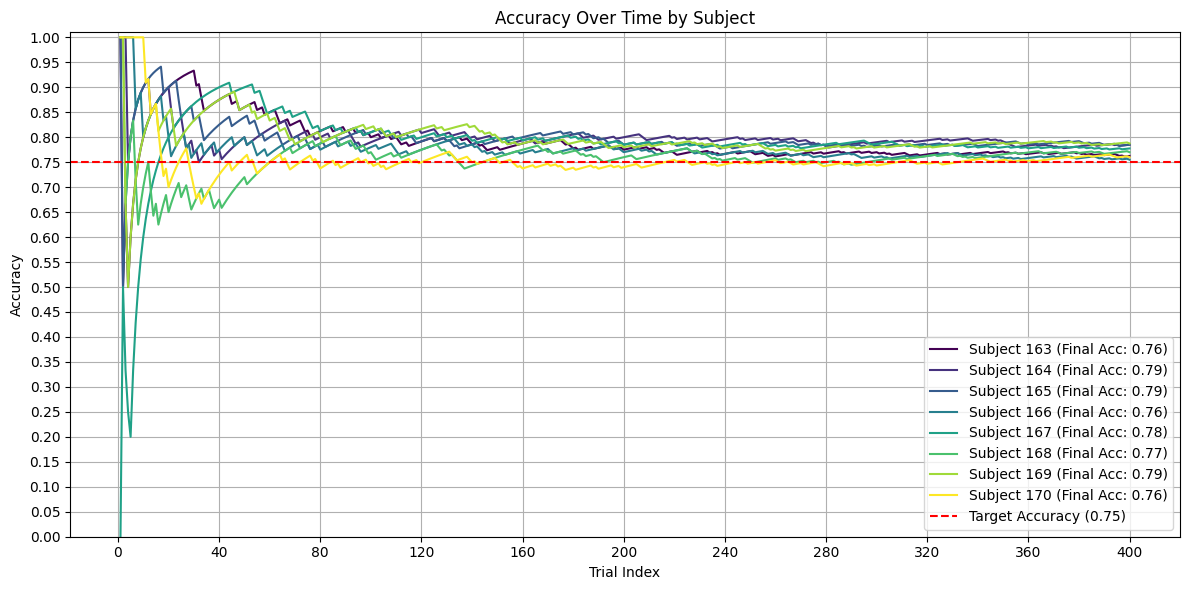

In [5]:
# Accuracy over time
plt.figure(figsize=(12, 6))
subjects = sorted(combined_df['subject'].unique())
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(subjects)))  # evenly spaced colors

# Loop through subjects with assigned colors
for color, subject in zip(colors, subjects):
    subject_data = combined_df[combined_df['subject'] == subject]
    
    # Get final accuracy at trial_index == 400, for labels
    final_acc = subject_data[subject_data['trial_index'] == 400]['accuracy'].values
    final_acc_str = f'{final_acc[0]:.2f}'
    
    plt.plot(
        subject_data['trial_index'],
        subject_data['accuracy'],
        label=f'Subject {subject} (Final Acc: {final_acc_str})',
        color=color
    )

# Reference line
plt.axhline(y=0.75, color='red', linestyle='--', linewidth=1.5, label='Target Accuracy (0.75)')

# Labels and title
plt.xlabel('Trial Index')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Time by Subject')

# Ticks and grid
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(40))
ax.yaxis.set_major_locator(MultipleLocator(0.05))
ax.set_ylim(0, 1.01)
plt.grid(True)

# Legend and layout
plt.legend()
plt.tight_layout()
plt.show()


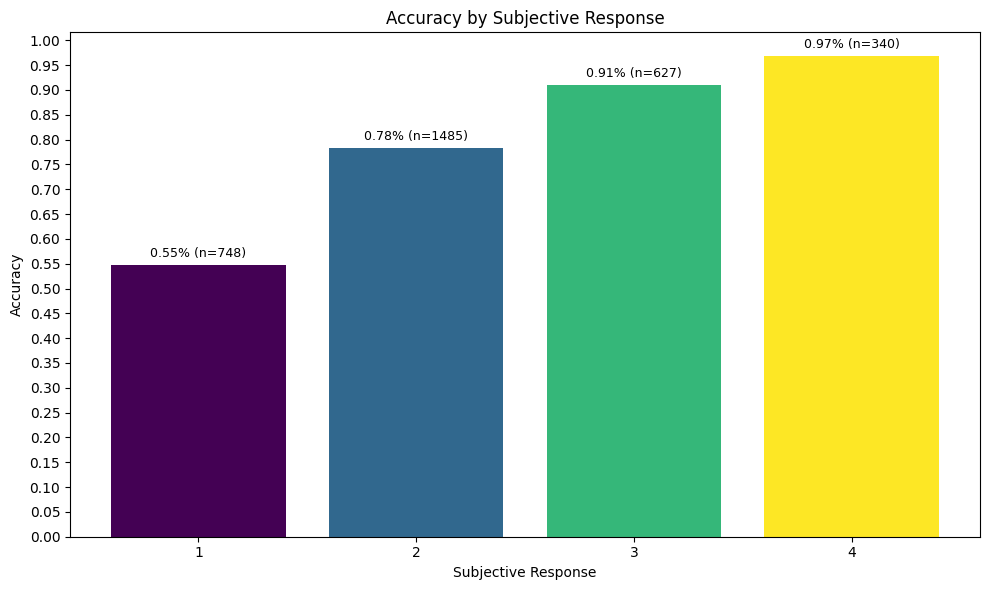

In [6]:
# Accuracy by subjective response
accuracy_by_response = (
    combined_df
    .groupby('subjective_response')['correct']
    .agg(['sum', 'count'])  # sum - how many times correct == True (i.e., correct responses), count = total trials
    .rename(columns={'sum': 'correct_count', 'count': 'total_count'})
)

accuracy_by_response['accuracy'] = accuracy_by_response['correct_count'] / accuracy_by_response['total_count']


# making a colormap from scratch using (e.g., 'viridis')
num_bars = len(accuracy_by_response)
colors = cm.viridis(np.linspace(0, 1, num_bars))

# Plotting bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(
    accuracy_by_response.index,
    accuracy_by_response['accuracy'],
    color=colors
)

# Annotating bars with accuracy and total count
for bar, acc, total in zip(bars,
                           accuracy_by_response['accuracy'],
                           accuracy_by_response['total_count']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.01,
        f"{acc:.2f}% (n={total})",   # show both accuracy and total count
        ha='center',
        va='bottom',
        fontsize=9
    )


# Axis labels and styling
plt.xlabel('Subjective Response')
plt.ylabel('Accuracy')
plt.title('Accuracy by Subjective Response')
plt.xticks(rotation=0)

# Tick spacing
ax = plt.gca()
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.05))

plt.tight_layout()
plt.show()

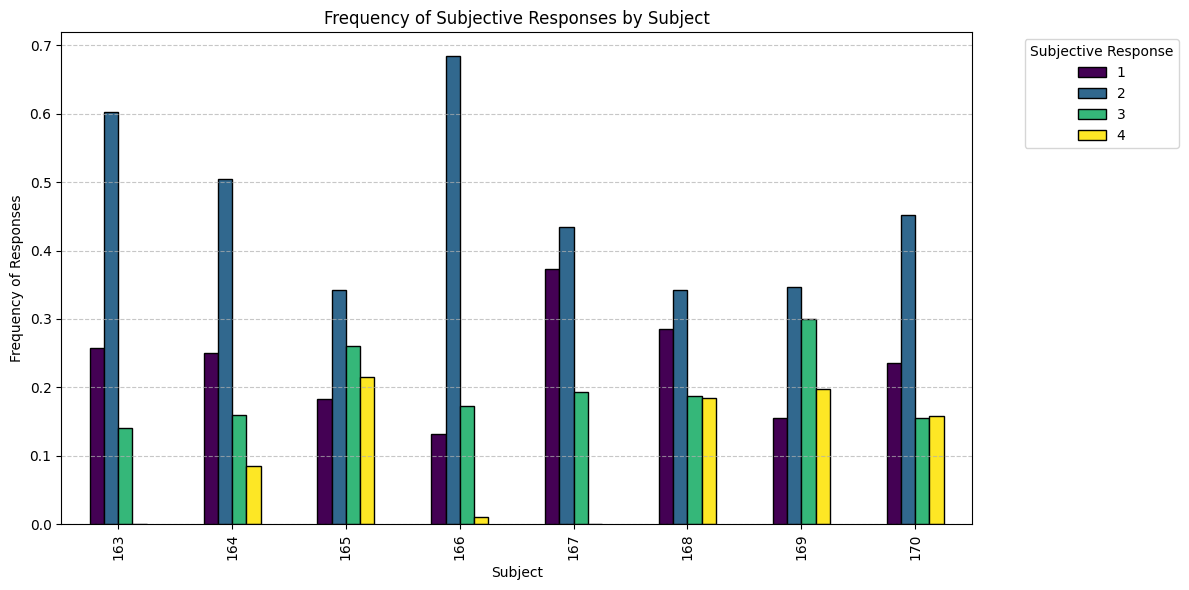

In [19]:
# Counting how many times each subject gave each subjective response
response_counts = (
    combined_df
    .groupby(['subject', 'subjective_response'])
    .size()
    .unstack(fill_value=0)  # Converts to wide format: rows = subjects, columns = responses
)

# Plotting grouped bar chart
(response_counts/400).plot(
    kind='bar',
    figsize=(12, 6),
    colormap='viridis',
    edgecolor='black'
)

plt.xlabel('Subject')
plt.ylabel('Frequency of Responses')
plt.title('Frequency of Subjective Responses by Subject')
plt.legend(title='Subjective Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


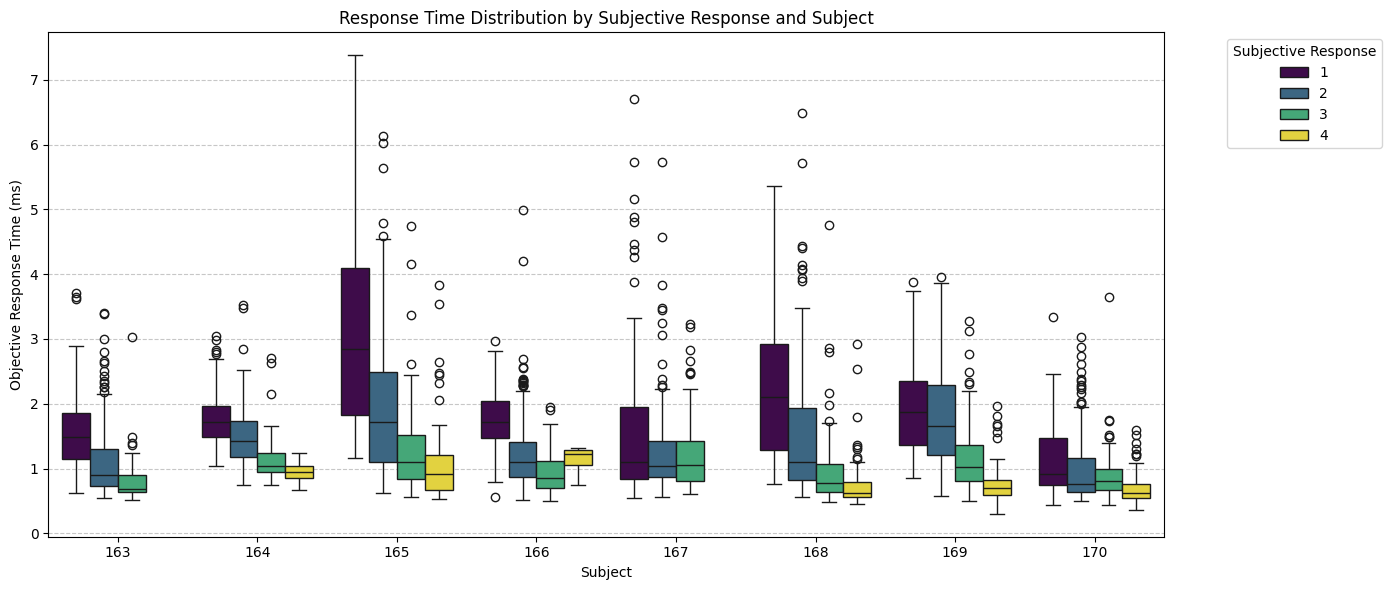

In [ ]:
# Set up the figure
plt.figure(figsize=(14, 6))

# Create boxplot: response time by subjective response, grouped by subject
sns.boxplot(
    data=combined_df,
    x='subject',
    y='objective_response_time_ms',
    hue='subjective_response',
    palette='viridis'
)

# Styling
plt.xlabel('Subject')
plt.ylabel('Objective Response Time (ms)')
plt.title('Response Time Distribution by Subjective Response and Subject')
plt.legend(title='Subjective Response', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

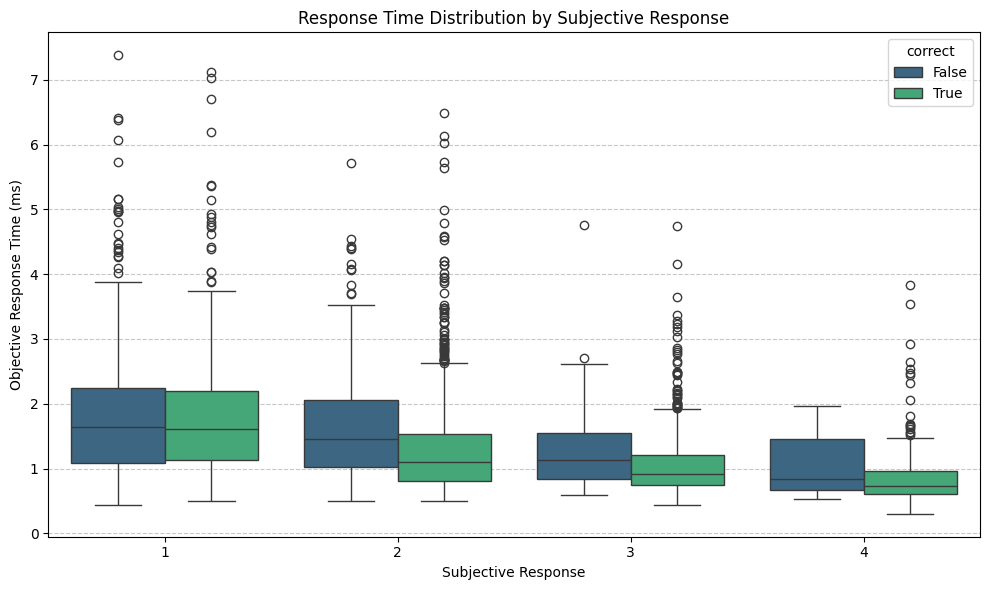

In [26]:
# Set up the figure
plt.figure(figsize=(10, 6))

# Create boxplot: response time by subjective response (across all subjects)
sns.boxplot(
    data=combined_df,
    x='subjective_response',
    y='objective_response_time_ms',
    hue='correct',
    palette='viridis'
)

# Styling
plt.xlabel('Subjective Response')
plt.ylabel('Objective Response Time (ms)')
plt.title('Response Time Distribution by Subjective Response')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Models?

In [ ]:
import statsmodels.formula.api as smf
import statsmodels.api as sm  # this gives access to families
# Ensure categorical variables are treated properly
combined_df['subject'] = combined_df['subject'].astype('category')
combined_df['subjective_response'] = combined_df['subjective_response'].astype('category')
combined_df['correct'] = combined_df['correct'].astype(int)



In [42]:
glm1 = smf.glm(
    formula='objective_response_time_ms ~ subjective_response',
    data=combined_df,
    family=sm.families.Gaussian()
).fit()
print(glm1.summary())

                     Generalized Linear Model Regression Results                      
Dep. Variable:     objective_response_time_ms   No. Observations:                 3200
Model:                                    GLM   Df Residuals:                     3196
Model Family:                        Gaussian   Df Model:                            3
Link Function:                       Identity   Scale:                         0.62453
Method:                                  IRLS   Log-Likelihood:                -3785.4
Date:                        Sat, 11 Oct 2025   Deviance:                       1996.0
Time:                                19:29:45   Pearson chi2:                 2.00e+03
No. Iterations:                             3   Pseudo R-squ. (CS):             0.1418
Covariance Type:                    nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [44]:
glm_2 = smf.glm(
    formula='objective_response_time_ms ~ subject + subjective_response + target_contrast + correct',
    data=combined_df,
    family=sm.families.Gaussian()
).fit()
print(glm_main.summary())

                     Generalized Linear Model Regression Results                      
Dep. Variable:     objective_response_time_ms   No. Observations:                 3200
Model:                                    GLM   Df Residuals:                     3187
Model Family:                        Gaussian   Df Model:                           12
Link Function:                       Identity   Scale:                         0.53567
Method:                                  IRLS   Log-Likelihood:                -3535.3
Date:                        Sat, 11 Oct 2025   Deviance:                       1707.2
Time:                                19:38:02   Pearson chi2:                 1.71e+03
No. Iterations:                             3   Pseudo R-squ. (CS):             0.2930
Covariance Type:                    nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------

In [ ]:
glm_interact1 = smf.glm(
    formula='objective_response_time_ms ~ subject + subjective_response * correct + target_contrast',
    data=combined_df,
    family=sm.families.Gaussian()
).fit()
print(glm_interact1.summary())


                     Generalized Linear Model Regression Results                      
Dep. Variable:     objective_response_time_ms   No. Observations:                 3200
Model:                                    GLM   Df Residuals:                     3184
Model Family:                        Gaussian   Df Model:                           15
Link Function:                       Identity   Scale:                         0.53292
Method:                                  IRLS   Log-Likelihood:                -3525.6
Date:                        Sat, 11 Oct 2025   Deviance:                       1696.8
Time:                                19:51:13   Pearson chi2:                 1.70e+03
No. Iterations:                             3   Pseudo R-squ. (CS):             0.2986
Covariance Type:                    nonrobust                                         
                                       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------

In [54]:
# Collect AIC and BIC
model_comparison = pd.DataFrame({
    'Model': [
        'GLM 1: subjective_response only',
        'GLM 2: + subject + contrast + correct',
        'GLM 3: + interaction (response × correct)'
    ],
    'AIC': [glm1.aic, glm_2.aic, glm_interact1.aic],
    'BIC': [glm1.bic, glm_2.bic, glm_interact1.bic]
}).sort_values(by='AIC')

print(model_comparison)

                                       Model          AIC           BIC
2  GLM 3: + interaction (response × correct)  7083.112532 -24000.961109
1      GLM 2: + subject + contrast + correct  7096.649415 -24014.782683
0            GLM 1: subjective_response only  7578.769579 -23798.627718


/work/nbs/env/lib/python3.12/site-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
